# Forecasting with ARMA Models

### Charles Becker
### 02/18/18

##### Import all relevent libraries and pull/assign water vapor data

In [82]:
import numpy as np
import xarray as xr # used to help convert NetCDF data to dataframe structure
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from pandas.core import datetools

a = xr.open_dataset('30_year_point_Q2.nc')

data = a.to_dataframe()  # create dataframe
Q2 = data['Q2'].values   # pull water vapor values

##### Since the dataset is so large, first I "slice" it by every 24th value to turn hourly data into daily data.  Secondly, I split the data into training and test data - train on the first 28 years and test on the last 2 years.

In [83]:
Q2_Daily = Q2[1::24]

train_Q2D = Q2_Daily[0:(10930-(365*2))] 
test_Q2D = Q2_Daily[-(365*2):]

##### Create an order 2 Autoregressive model (AR(2)) from the training data and assign the model parameters to variables.

In [98]:
QD_AR2_model = sm.AR(train_Q2D).fit(2)

QD_AR2_mu = QD_AR2_model.params[0]
QD_AR2_phi_1 = QD_AR2_model.params[1]
QD_AR2_phi_2 = QD_AR2_model.params[2]

##### Combine the previous 2 values from the beggining of the test set (which are the last two of the training set).  Then create a forecast from 0-5 timesteps based on a combination of the model parameters and previous values.

In [86]:
QD_AR2_cat = np.concatenate([train_Q2D[-3:-1],test_Q2D[0:99]])

QD_AR_Z_hat = QD_AR2_mu + QD_AR2_phi_1*QD_AR2_cat[1:99] + QD_AR2_phi_2*QD_AR2_cat[0:98] 

QD_AR_lead_1 = QD_AR2_mu + QD_AR2_phi_1*QD_AR_Z_hat + QD_AR2_phi_2*QD_AR2_cat[1:99]
QD_AR_lead_2 = QD_AR2_mu + QD_AR2_phi_1*QD_AR_lead_1 + QD_AR2_phi_2*QD_AR_Z_hat
QD_AR_lead_3 = QD_AR2_mu + QD_AR2_phi_1*QD_AR_lead_2 + QD_AR2_phi_2*QD_AR_lead_1
QD_AR_lead_4 = QD_AR2_mu + QD_AR2_phi_1*QD_AR_lead_3 + QD_AR2_phi_2*QD_AR_lead_2
QD_AR_lead_5 = QD_AR2_mu + QD_AR2_phi_1*QD_AR_lead_4 + QD_AR2_phi_2*QD_AR_lead_3

##### Create a white noise timeseries of equal length to my test dataset by taking the standard deviation of the predictions of the AR model and using that as the standard deviation in a random number generator with a mean of zero.  Create an order 2,2 autoregressive moving average model and assign the model parameters to variables.  Lastly, use the parameters (and noise) to forecast from lead times 0-5 days. 

In [111]:
std_noise = np.std(QD_AR_Z_hat - QD_AR2_cat[0:-3])

eta = np.random.normal(0.0,std_noise,98)
etatm1 = np.concatenate([np.random.normal(0.0,std_noise,1),eta[0:-1]])
etatm2 = np.concatenate([np.random.normal(0.0,std_noise,2),etatm1[0:-2]])

Q_ARMA22 = sm.ARMA(train_Q2D,(2,2)).fit()

ARMA22_mu      = Q_ARMA22.params[0]
ARMA22_phi_1   = Q_ARMA22.params[1]
ARMA22_phi_2   = Q_ARMA22.params[2]
ARMA22_theta_1 = Q_ARMA22.params[3]
ARMA22_theta_2 = Q_ARMA22.params[4]

QD_ARMA_Z_hat = ARMA22_phi_1*QD_AR2_cat[1:99] + ARMA22_phi_2*QD_AR2_cat[0:98] \
    - ARMA22_theta_1*etatm1 - ARMA22_theta_2*etatm2
    
QD_ARMA_lead_1 =  ARMA22_phi_1*QD_ARMA_Z_hat + ARMA22_phi_2*QD_AR2_cat[1:99] \
    - ARMA22_theta_1*eta - ARMA22_theta_2*etatm1
QD_ARMA_lead_2 = ARMA22_phi_1*QD_ARMA_lead_1 + ARMA22_phi_2*QD_ARMA_Z_hat \
    - ARMA22_theta_1*eta 
QD_ARMA_lead_3 = ARMA22_phi_1*QD_ARMA_lead_2 + ARMA22_phi_2*QD_ARMA_lead_1 
QD_ARMA_lead_4 = ARMA22_phi_1*QD_ARMA_lead_3 + ARMA22_phi_2*QD_ARMA_lead_2 
QD_ARMA_lead_5 = ARMA22_phi_1*QD_ARMA_lead_4 + ARMA22_phi_2*QD_ARMA_lead_3 


##### Print a summary of the parameters from the ARMA(2,2) model we created

In [113]:
Q_ARMA22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10200
Model:                     ARMA(2, 2)   Log Likelihood               54599.184
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 19 Mar 2018   AIC                        -109186.368
Time:                        22:48:13   BIC                        -109142.987
Sample:                             0   HQIC                       -109171.698
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.000     26.363      0.000       0.004       0.004
ar.L1.y        1.4796      0.021     69.345      0.000       1.438       1.521
ar.L2.y       -0.4856      0.021    -23.271      0.000      -0.526      -0.445
ma.L1.y       -0.9094      0.023    -39.054      0.000      -0.955      -0.864
ma.L2.y       -0.0126      0.019     -0.657      0.511      -0.050       0.025
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0119           +0.0000j            1.0119            0.0000
AR.2            2.0352           +0.0000j            2.0352            0.0000
MA.1            1.0834           +0.0000j            1.0834            0.0000
MA.2          -73.4312           +0.0000j           73.4312            0.5000
-----------------------------------------------------------------------------
"""

##### Plot the 1-day, 3-day, and 5-day forecasts for the AR(2) model against the observed test data.

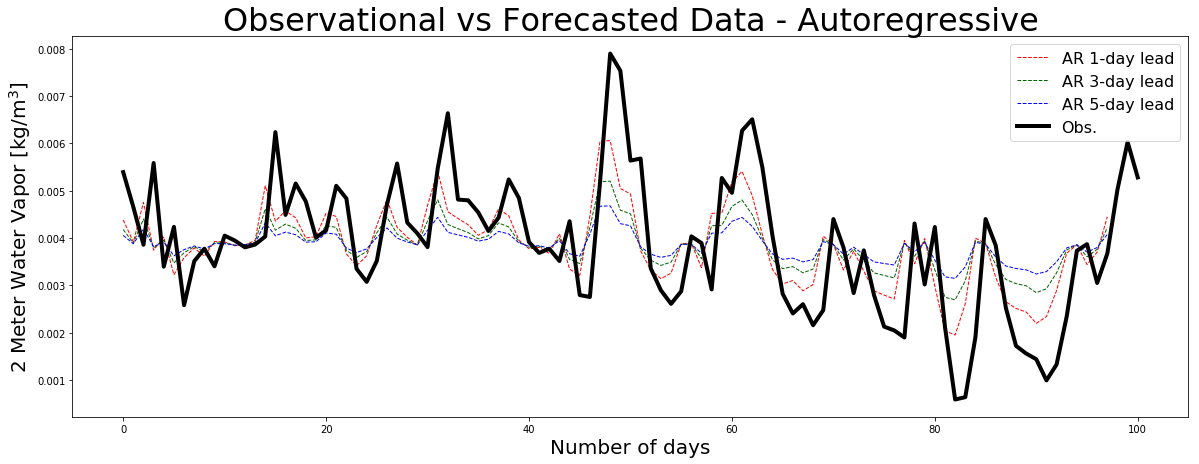

In [89]:
plt.figure(figsize=(20,7))
plt.plot(QD_AR_lead_1, linewidth = 1, color = 'red', ls = '--')
plt.plot(QD_AR_lead_3,linewidth = 1, color = 'darkgreen',ls = '--')
plt.plot(QD_AR_lead_5,linewidth = 1, color = 'blue', ls = '--')
plt.plot(QD_AR2_cat,linewidth = 4, color = 'black')

plt.title('Observational vs Forecasted Data - Autoregressive', fontsize = 32)
plt.ylabel('2 Meter Water Vapor [kg/m${}^3$]',fontsize=20)
plt.xlabel('Number of days',fontsize=20)
plt.legend(('AR 1-day lead','AR 3-day lead','AR 5-day lead','Obs.'),fontsize=16)
plt.show()



##### Plot the 1-day, 3-day, and 5-day forecasts for the ARMA(2,2) model against the observed test data.

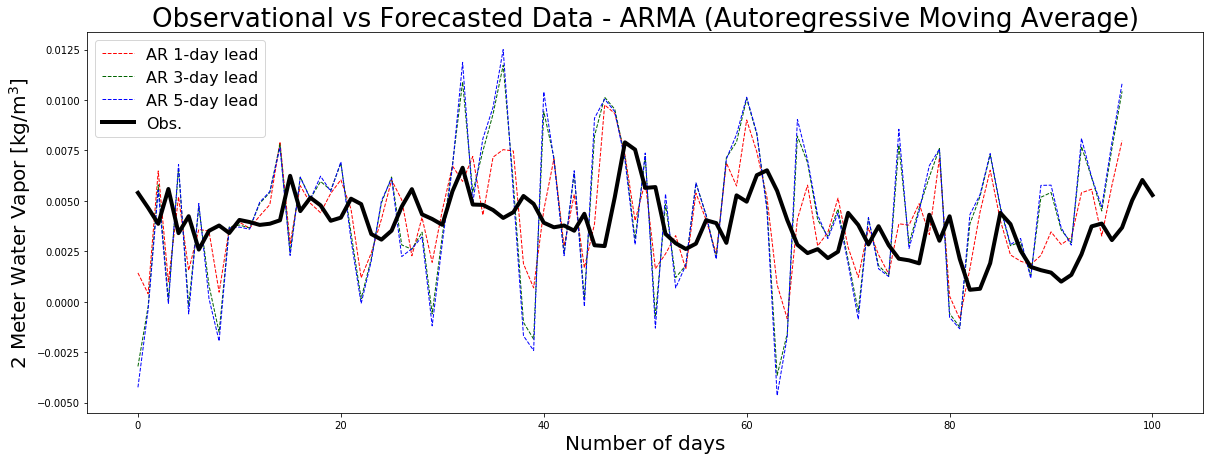

In [112]:
plt.figure(figsize=(20,7))
plt.plot(QD_ARMA_lead_1, linewidth = 1, color = 'red', ls = '--')
plt.plot(QD_ARMA_lead_3,linewidth = 1, color = 'darkgreen',ls = '--')
plt.plot(QD_ARMA_lead_5,linewidth = 1, color = 'blue', ls = '--')
plt.plot(QD_AR2_cat,linewidth = 4, color = 'black')
#plt.plot(QD_ARMA_Z_hat,linewidth = 4, color = 'red')

plt.title('Observational vs Forecasted Data - ARMA (Autoregressive Moving Average)', fontsize = 26)
plt.ylabel('2 Meter Water Vapor [kg/m${}^3$]',fontsize=20)
plt.xlabel('Number of days',fontsize=20)
plt.legend(('AR 1-day lead','AR 3-day lead','AR 5-day lead','Obs.'),fontsize=16)
plt.show()



##### Calculate error statistics for R^2, mean error, and standard deviation of the error for both the AR and ARMA models.

In [88]:
R2AR_1day  = np.corrcoef(QD_AR_lead_1,QD_AR2_cat[:-3])**2
muAR_1day  = np.mean(QD_AR_lead_1-QD_AR2_cat[:-3])
stdAR_1day = np.std(QD_AR_lead_1-QD_AR2_cat[:-3])

R2AR_3day  = np.corrcoef(QD_AR_lead_3,QD_AR2_cat[:-3])**2
muAR_3day  = np.mean(QD_AR_lead_3-QD_AR2_cat[:-3])
stdAR_3day = np.std(QD_AR_lead_3-QD_AR2_cat[:-3])

R2AR_5day  = np.corrcoef(QD_AR_lead_5,QD_AR2_cat[:-3])**2
muAR_5day  = np.mean(QD_AR_lead_5-QD_AR2_cat[:-3])
stdAR_5day = np.std(QD_AR_lead_5-QD_AR2_cat[:-3])

R2ARMA_1day  = np.corrcoef(QD_ARMA_lead_1,QD_AR2_cat[:-3])**2
muARMA_1day  = np.mean(QD_ARMA_lead_1-QD_AR2_cat[:-3])
stdARMA_1day = np.std(QD_ARMA_lead_1-QD_AR2_cat[:-3])

R2ARMA_3day  = np.corrcoef(QD_ARMA_lead_3,QD_AR2_cat[:-3])**2
muARMA_3day  = np.mean(QD_ARMA_lead_3-QD_AR2_cat[:-3])
stdARMA_3day = np.std(QD_ARMA_lead_3-QD_AR2_cat[:-3])

R2ARMA_5day  = np.corrcoef(QD_ARMA_lead_5,QD_AR2_cat[:-3])**2
muARMA_5day  = np.mean(QD_ARMA_lead_5-QD_AR2_cat[:-3])
stdARMA_5day = np.std(QD_ARMA_lead_5-QD_AR2_cat[:-3])

##### Create table to display error statistics for both models (this is clearly hacked together - I'm sure there's a much more elegant way to acheive this).

In [94]:
print("                  AR              ARMA")
print("")
print("R2 (1)           ",np.round(R2AR_1day[1,0],5),"       ",np.round(R2ARMA_1day[1,0],5))
print("R2 (3)           ",np.round(R2AR_3day[1,0],5),"       ",np.round(R2ARMA_3day[1,0],5))
print("R2 (5)           ",np.round(R2AR_5day[1,0],5),"       ",np.round(R2ARMA_5day[1,0],5))
print("")
print("Mean Error (1)   ",np.round(muAR_1day,5),"         ",np.round(muARMA_1day,5))
print("Mean Error (3)   ",np.round(muAR_3day,5),"         ",np.round(muARMA_3day,5))
print("Mean Error (5)   ",np.round(muAR_5day,5),"        ",np.round(muARMA_5day,5))
print("")
print("STD of Error (1) ",np.round(stdAR_1day,5),"       ",np.round(stdARMA_1day,5))
print("STD of Error (3) ",np.round(stdAR_3day,5),"       ",np.round(stdARMA_3day,5))
print("STD of Error (5) ",np.round(stdAR_5day,5),"       ",np.round(stdARMA_5day,5))


                  AR              ARMA

R2 (1)            0.56092         0.04906
R2 (3)            0.56439         0.00748
R2 (5)            0.56451         0.00437

Mean Error (1)    1e-05           5e-05
Mean Error (3)    2e-05           6e-05
Mean Error (5)    2e-05          -1e-05

STD of Error (1)  0.00096         0.00239
STD of Error (3)  0.00108         0.00373
STD of Error (5)  0.00119         0.00406


##### Daily water vapor data is clearly a noisy process, and distinguishing between signal and noise is not easy.  The AR model has correlation coefficients which aren't terribly great at about 0.56, but that is to be expected with such a noisy process.  You can see the forecasted data clearly regress towrads the mean as your forecsating lead time increases - which is expected with an AR model.  

##### The ARMA model on the other hand, does a very poor job of modeling the process, most likely since the process is too noisy.  I don't entirely understand why the amplitude of the forecast signal seems to increase with increased lead times.  The mean error of the model is good, but clearly it only really means that there is no directional bias in the error - it's just really bad in both directions.  Clearly, the AR model is the better choice here.